In [1]:
# Essentials
import numpy as np
import math
import pandas as pd
import datetime
import random
from datetime import datetime
# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import pickle

# Ignore useless warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
df_bikes = pd.read_csv('C:\\Users\\Charne\\Documents\\greenhouse_rentals\\static\\SeoulBikeData_cleaned.csv', encoding= 'unicode_escape')

In [3]:
df_bikes.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Year,Month,Day,DOW,isWeekend,isHoliday,isFunctioningDay,RentedBikes_Log
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,2017,1,12,3,0,0,1,5.541264
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,2017,1,12,3,0,0,1,5.323010
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,2017,1,12,3,0,0,1,5.159055
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,2017,1,12,3,0,0,1,4.682131
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,2017,1,12,3,0,0,1,4.369448


#### Define X and Y

In [4]:
# Define model variables
y = df_bikes['RentedBikes_Log']
df_train = df_bikes.drop(['RentedBikes_Log', 'Rented Bike Count', 'Date'], axis= 1).copy()

#### Dummy encode categorical variable

In [5]:
df_train = pd.get_dummies(df_train, columns=["Seasons"])

#### Scale features

In [6]:
# create scaler object
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train)

In [7]:
X_scaled.shape

(8760, 20)

## Key features of the model training process:
 - __Cross Validation:__ Using 12-fold cross-validation
 - __Models:__ On each run of cross-validation I fit 7 models (ridge, svr, gradient boosting, random forest, xgboost, lightgbm regressors)
 - __Stacking:__ In addition, I trained a meta StackingCVRegressor optimized using xgboost
 - __Blending:__ All models trained will overfit the training data to varying degrees. Therefore, to make final predictions, I blended their predictions together to get more robust predictions.

## Setup cross validation and define error metrics

In [8]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [9]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

### Setup models

In [10]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
print('X_train : ' + str(X_train.shape))
print('X_test : ' + str(X_test.shape))
print('y_train : ' + str(y_train.shape))
print('y_test : ' + str(y_test.shape))

X_train : (7008, 20)
X_test : (1752, 20)
y_train : (7008,)
y_test : (1752,)


In [11]:
# Light Gradient Boosting Regressor
# lightgbm = LGBMRegressor(objective='regression', 
#                        num_leaves=6,
#                        learning_rate=0.01, 
#                        n_estimators=7000,
#                        max_bin=200, 
#                        bagging_fraction=0.8,
#                        bagging_freq=4, 
#                        bagging_seed=8,
#                        feature_fraction=0.2,
#                        feature_fraction_seed=8,
#                        min_sum_hessian_in_leaf = 11,
#                        verbose=-1,
#                        random_state=42)

In [12]:
# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

In [13]:
# Ridge Regressor
ridge_alphas = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, 3, 5, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

In [14]:
cv_ridge = [cv_rmse(Ridge(alpha = alpha), X_train, y_train).mean() 
            for alpha in ridge_alphas]

Text(0, 0.5, 'rmse')

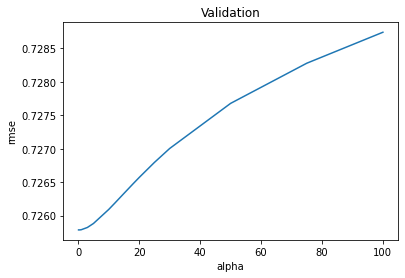

In [15]:
cv_ridge = pd.Series(cv_ridge, index = ridge_alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [16]:
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

In [17]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [18]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## Train models

Get cross validation scores for each model

In [19]:
%%time
# Fit all models
start_time = datetime.now()

print('stack_gen')
stack_model = stack_gen.fit(np.array(X_train), np.array(y_train))
runtime = datetime.now() - start_time
print('Total runtime for stacked model: ', runtime)

print('xgboost')
xgb_model = xgboost.fit(X_train, y_train)
runtime = datetime.now() - start_time
print('Total runtime for XGBoost: ', runtime)

print('Ridge')
ridge_model = ridge.fit(X_train, y_train)
runtime = datetime.now() - start_time
print('Total runtime for Ridge regressor: ', runtime)

print('RandomForest')
rf_model = rf.fit(X_train, y_train)
runtime = datetime.now() - start_time
print('Total runtime for Random forest: ', runtime)

print('GradientBoosting')
gbr_model = gbr.fit(X_train, y_train)
runtime = datetime.now() - start_time
print('Total runtime for gradient boosting: ', runtime)

stack_gen
[11:58:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[11:59:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression